In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [35]:
scores_st = [
{'r2 mean': 0.6571610303680655, 'r2 std': 0.032572135933967246, 'rmse mean': 1.147067002227973, 'rmse std': 0.05359295019205026},
{'r2 mean': 0.696297613698292, 'r2 std': 0.040835502554000466, 'rmse mean': 1.0106739136248548, 'rmse std': 0.045704741851971334},
{'r2 mean': 0.690534623260907, 'r2 std': 0.06184343517089181, 'rmse mean': 1.0172932433069881, 'rmse std': 0.06902758468519067},
{'r2 mean': 0.716188339332361, 'r2 std': 0.04877404249436462, 'rmse mean': 0.9775043363906827, 'rmse std': 0.06428197359798228},
{'r2 mean': 0.6771786600248746, 'r2 std': 0.08891697359012948, 'rmse mean': 1.0246648545711594, 'rmse std': 0.12569763189365132}
]

scores_trfm = [
{'r2 mean': 0.7085895841847331, 'r2 std': 0.03621089304339123, 'rmse mean': 1.0536645220014162, 'rmse std': 0.04815102448152685},
{'r2 mean': 0.8022335385568408, 'r2 std': 0.016215896154481803, 'rmse mean': 0.897452393465646, 'rmse std': 0.02502811946552656},
{'r2 mean': 0.8405405173053863, 'r2 std': 0.014581732103992067, 'rmse mean': 0.8104924670590983, 'rmse std': 0.02766244388976758},
{'r2 mean': 0.850203780293822, 'r2 std': 0.015574507311383544, 'rmse mean': 0.7876886489727613, 'rmse std': 0.040092581701085345},
{'r2 mean': 0.856646733606369, 'r2 std': 0.04219085726451124, 'rmse mean': 0.7582843666792691, 'rmse std': 0.09295171030292039}
]
scores_ecfp4=[
{'r2 mean': -0.1182601549079639, 'r2 std': 0.38492231932689197, 'rmse mean': 1.7046461962569939, 'rmse std': 0.064028737168511},
{'r2 mean': 0.4200801070248882, 'r2 std': 0.056323869062615314, 'rmse mean': 1.5330984002474106, 'rmse std': 0.058330132808446886},
{'r2 mean': 0.5142260496738709, 'r2 std': 0.03488870888296532, 'rmse mean': 1.4796416953603162, 'rmse std': 0.04998929662590407},
{'r2 mean': 0.5517382840343468, 'r2 std': 0.04070523389695399, 'rmse mean': 1.4144024916614077, 'rmse std': 0.06294831164905162},
{'r2 mean': 0.6020391672882388, 'r2 std': 0.07006047612774513, 'rmse mean': 1.3241745714040831, 'rmse std': 0.10213747489123697}
]
scores_rnn = [
{'r2 mean': 0.6112213241376161, 'r2 std': 0.0453378178104482, 'rmse mean': 1.2679561424642765, 'rmse std': 0.060991651614237107},
{'r2 mean': 0.7403670136642482, 'r2 std': 0.02343635306087596, 'rmse mean': 0.9967447340148177, 'rmse std': 0.03065637528528513},
{'r2 mean': 0.7609176628617642, 'r2 std': 0.03315035278692055, 'rmse mean': 0.9399822526227863, 'rmse std': 0.044213111390548565},
{'r2 mean': 0.7907016856068074, 'r2 std': 0.024243515357136838, 'rmse mean': 0.8892742685018554, 'rmse std': 0.03978827595120653},
{'r2 mean': 0.7546840686854882, 'r2 std': 0.04094441642979718, 'rmse mean': 0.9388279314745732, 'rmse std': 0.0714152997278168}
]
scores_gc = [
{'r2 mean': 0.21890250990726204, 'r2 std': 0.07381879126556154, 'rmse mean': 1.8429856337306183, 'rmse std': 0.08739237277147067},
{'r2 mean': 0.5563064786186135, 'r2 std': 0.07246171936294994, 'rmse mean': 1.3880360761230484, 'rmse std': 0.1161028613690809},
{'r2 mean': 0.6608510694945265, 'r2 std': 0.06851655478404685, 'rmse mean': 1.2253566948338137, 'rmse std': 0.12372734445062651},
{'r2 mean': 0.7561302082858733, 'r2 std': 0.054626548782266596, 'rmse mean': 1.0387756727933906, 'rmse std': 0.12601494762902174},
{'r2 mean': 0.8148924716400823, 'r2 std': 0.03176142362012494, 'rmse mean': 0.8677234443263296, 'rmse std': 0.09109165427656797}
]
scores_gae=[
{'r2 mean': 0.28032776829694683, 'r2 std': 0.09340462615634937, 'rmse mean': 1.8550083625098572, 'rmse std': 0.2024013609462288},
{'r2 mean': 0.4908138859485501, 'r2 std': 0.05497909175167818, 'rmse mean': 1.544493428107669, 'rmse std': 0.08323523501302978},
{'r2 mean': 0.5626690071994529, 'r2 std': 0.0630935820731443, 'rmse mean': 1.3787549595351156, 'rmse std': 0.21300371475203592},
{'r2 mean': 0.6014172466286762, 'r2 std': 0.046772183356212006, 'rmse mean': 1.2658116057443871, 'rmse std': 0.0789094833288315},
{'r2 mean': 0.5749047753758626, 'r2 std': 0.09812030893474082, 'rmse mean': 1.1741714935099299, 'rmse std': 0.08498478319827273}
]

In [36]:
r = np.arange(0.1, 1, 0.2)

In [37]:
def dict_to_arr(scores_dict):
    r2, rmse = np.empty((2,len(scores_ecfp4))), np.empty((2,len(scores_ecfp4)))
    for i,s in enumerate(scores_dict):
        r2[0,i] = s['r2 mean']
        r2[1,i] = s['r2 std']
        rmse[0,i] = s['rmse mean']
        rmse[1,i] = s['rmse std']
    return r2, rmse
    

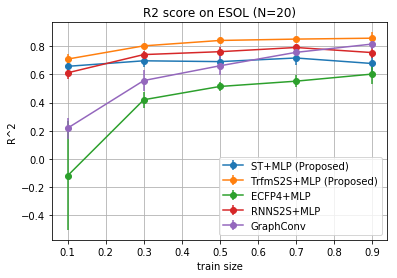

In [40]:
plt.figure(figsize=(6,4))
r2_1, rmse_1 = dict_to_arr(scores_st)
r2_2, rmse_2 = dict_to_arr(scores_trfm)
r2_3, rmse_3 = dict_to_arr(scores_ecfp4)
r2_4, rmse_4 = dict_to_arr(scores_rnn)
r2_5, rmse_5 = dict_to_arr(scores_gc)
plt.errorbar(r, r2_1[0], yerr=r2_1[1], fmt='o-', label='ST+MLP (Proposed)')
plt.errorbar(r, r2_2[0], yerr=r2_2[1], fmt='o-', label='TrfmS2S+MLP (Proposed)')
plt.errorbar(r, r2_3[0], yerr=r2_3[1], fmt='o-', label='ECFP4+MLP')
plt.errorbar(r, r2_4[0], yerr=r2_4[1], fmt='o-', label='RNNS2S+MLP')
plt.errorbar(r, r2_5[0], yerr=r2_5[1], fmt='o-', label='GraphConv')
plt.xlabel('train size')
plt.ylabel('R^2')
plt.title('R2 score on ESOL (N=20)')
plt.legend()
plt.grid()
plt.show()

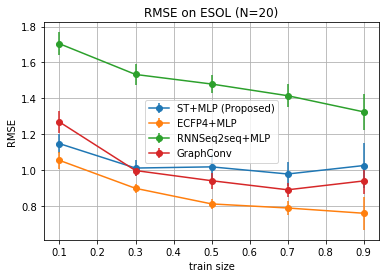

In [39]:
plt.errorbar(r, rmse_1[0], yerr=rmse_1[1], fmt='o-', label='ST+MLP (Proposed)')
plt.errorbar(r, rmse_2[0], yerr=rmse_2[1], fmt='o-', label='ECFP4+MLP')
plt.errorbar(r, rmse_3[0], yerr=rmse_3[1], fmt='o-', label='RNNSeq2seq+MLP')
plt.errorbar(r, rmse_4[0], yerr=rmse_4[1], fmt='o-', label='GraphConv')
plt.xlabel('train size')
plt.ylabel('RMSE')
plt.title('RMSE on ESOL (N=20)')
plt.legend()
plt.grid()
plt.show()

In [27]:
X1 = [
[0.72729178, 0.01583617],
[0.75311616, 0.01053973],
[0.76315039, 0.0131799 ],
[0.76984735, 0.02055655],
[0.77098238, 0.03656447]
]
X1 = np.array(X1)
X2 = [
[0.49014492, 0.01986358],
[0.4883367,  0.02578929],
[0.48641916, 0.03304265],
[0.48915604, 0.05061128],
[0.49556962, 0.10761644]
]
X2 = np.array(X2)
X3 = [
[0.70373086, 0.02413519],
[0.73516067, 0.0175177 ],
[0.7520828,  0.01741818],
[0.75973676, 0.02319038],
[0.7728253,  0.04110161]
]
X3 = np.array(X3)
X4 = [
[0.6975050137485098, 0.027513840142453033],
[0.7671855796536491, 0.01604441693108415],
[0.7921102780940512, 0.014881537969910076],
[0.8066619732919259, 0.0206563120633069],
[0.8226198522794377, 0.03764091725565298]
]
X4 = np.array(X4)

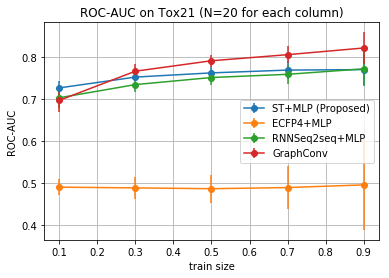

In [28]:
plt.figure(figsize=(6,4))
plt.errorbar(r, X1[:,0], yerr=X1[:,1], fmt='o-', label='ST+MLP (Proposed)')
plt.errorbar(r, X2[:,0], yerr=X2[:,1], fmt='o-', label='ECFP4+MLP')
plt.errorbar(r, X3[:,0], yerr=X3[:,1], fmt='o-', label='RNNSeq2seq+MLP')
plt.errorbar(r, X4[:,0], yerr=X4[:,1], fmt='o-', label='GraphConv')
plt.xlabel('train size')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC on Tox21 (N=20 for each column)')
plt.legend()
plt.grid()
plt.show()

In [29]:
scores_st = [
{'auc mean': 0.6802248631267924, 'auc std': 0.06574173206983559},
{'auc mean': 0.7233207429407713, 'auc std': 0.01835838120962726},
{'auc mean': 0.7491484184914843, 'auc std': 0.019053491380602045},
{'auc mean': 0.7664026286451916, 'auc std': 0.022419978041062993},
{'auc mean': 0.7763576043303649, 'auc std': 0.03538671464869024}
]
scores_ecfp4 = [
{'auc mean': 0.7914059920048666, 'auc std': 0.017291683925677634},
{'auc mean': 0.841849693669651, 'auc std': 0.012279319625548204},
{'auc mean': 0.8546504718506954, 'auc std': 0.012153422988836664},
{'auc mean': 0.8670573451465898, 'auc std': 0.013544194992219167},
{'auc mean': 0.8771040684477038, 'auc std': 0.02512422514850564}
]
scores_rnn = [
{'auc mean': 0.7266682236899279, 'auc std': 0.026731095500876507},
{'auc mean': 0.8081916465794305, 'auc std': 0.015618051549232561},
{'auc mean': 0.8334757323882256, 'auc std': 0.010426107287843257},
{'auc mean': 0.8408985116078938, 'auc std': 0.013627318787260553},
{'auc mean': 0.8575082940457481, 'auc std': 0.03078200363096277}
]
scores_gc = [
{'auc mean': 0.7731164873063542, 'auc std': 0.019381973618736673},
{'auc mean': 0.827707085952707, 'auc std': 0.012863222703762464},
{'auc mean': 0.8545468114846569, 'auc std': 0.013610841626666363},
{'auc mean': 0.8624702249221473, 'auc std': 0.01950053282351519},
{'auc mean': 0.8796838522160145, 'auc std': 0.029846762225770766}
]

In [30]:
def dict_to_arr(scores_dict):
    auc = np.empty((2,len(scores_dict)))
    for i,s in enumerate(scores_dict):
        auc[0,i] = s['auc mean']
        auc[1,i] = s['auc std']
    return auc

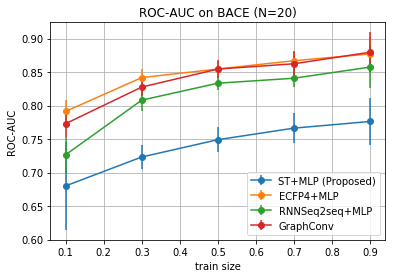

In [32]:
plt.figure(figsize=(6,4))
auc_1 = dict_to_arr(scores_st)
auc_2 = dict_to_arr(scores_ecfp4)
auc_3 = dict_to_arr(scores_rnn)
auc_4 = dict_to_arr(scores_gc)
plt.errorbar(r, auc_1[0], yerr=auc_1[1], fmt='o-', label='ST+MLP (Proposed)')
plt.errorbar(r, auc_2[0], yerr=auc_2[1], fmt='o-', label='ECFP4+MLP')
plt.errorbar(r, auc_3[0], yerr=auc_3[1], fmt='o-', label='RNNSeq2seq+MLP')
plt.errorbar(r, auc_4[0], yerr=auc_4[1], fmt='o-', label='GraphConv')
plt.xlabel('train size')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC on BACE (N=20)')
plt.legend()
plt.grid()
plt.show()